# Welcome to the 2D Truss Solver
# by Shashank Tyagi

In [40]:
# Importing Essential Libraries
from IPython.display import Image
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import copy
import math
import matplotlib.patches as mpatches

#### Step 1 - Making the Data Entry
This is the only step to be entered by the user.
The User is advised to go through the instructions given carefully.
A sample entry is provided in the cell below. Please refer it and update it according to your requirement.

DATA ENTRIES INSTRUCTION -

1. E (type - float)
   Details - Young Modulus of the members
2. A (type - float)
    Details - Cross Sectional Area of the members
3. xFactor (type - float)
    Details - Factor to Scale the displacment to visulize the displaced truss.
4. nodes (type - np.array)
    Details - This is an np array of coordinate of all the nodes in the truss in 2D space.
5. members (type - np.array)
    Details - An np array indicating the start and end node of all the members.
    Prefebrally first horizontal, secondly vertical members and finally the diagonal member
6. forceVector (type - np.array)
        Details - An np.array of size (1,DoF) indicating the external load at the degree of freedom, where DoF - Degree of         freedom
#### Please go through the Sample Input given below for better understanding.

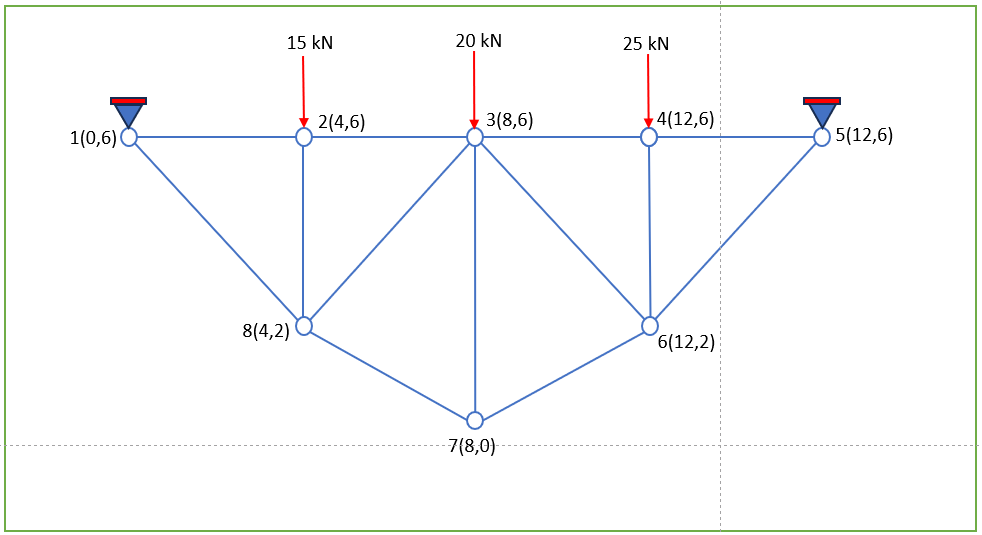

In [97]:
from IPython.display import Image

# Specify the path to the image file
image_path = 'SAMPLE TRUSS PIC.png'  # Replace with the actual path to your image

# Display the image
Image(filename=image_path)

In [98]:
#=================================START OF DATA ENTRY================================
#Constants
E = 200*10**9 #(N/m^2)
A = 0.005 #(m^2)
xFac = 500 #Scale factor for plotted displacements

#Nodal coordinates [x, y] (in ascending node order)
nodes = np.array([[0,6], # Coordinates of Node 1
                  [4,6], # Coordinates of Node 2 and SO ON....
                  [8,6],
                  [12,6],
                  [16,6],
                  [12,2],           
                  [8,0],
                  [4,2]
                 ])

#Members [node_i, node_j]
members = np.array([[1,2], # Member 1 Extending from Node 1 to Node 2
                   [2,3],
                   [3,4],
                   [4,5],
                   [5,6],
                   [6,7],
                   [7,8],
                   [1,8],
                   [2,8],
                   [3,7],
                   [4,6],
                   [3,8],
                   [3,6]
                   ])

#Supports
restrainedDoF = [1,2,10] #The degrees of freedom restrained by supports, Here 1 indicate 1st dof and SO ON...


#Loading
forceVector = np.array([np.zeros(16)]).T # A zero nd.array of size (2* number of node)
forceVector[3] = -15000 # if force in 4th dof is X(N), Enter forceVector[3] = X and SO ON....  
forceVector[5] = -2000
forceVector[7] = -25000
#=================================END OF DATA ENTRY================================

#### Step 2 : Plotting the Truss
You can check if the data entry that you is correct.

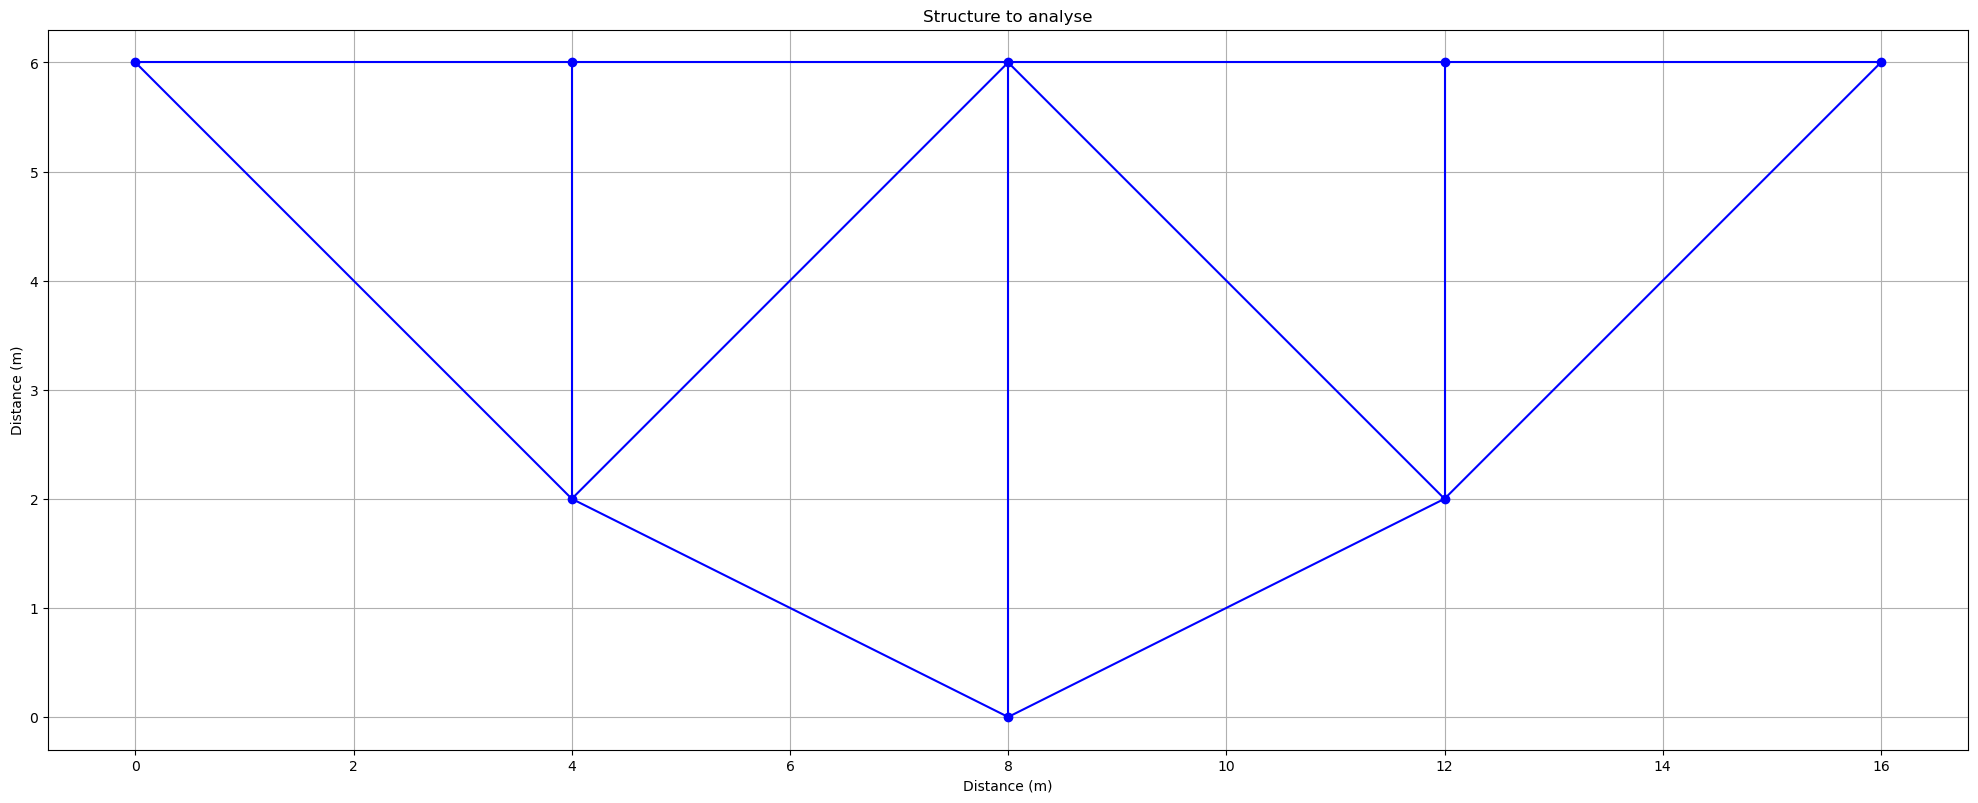

In [99]:
fig = plt.figure() 
axes = fig.add_axes([0.1,0.1,3,3]) 
fig.gca().set_aspect('equal', adjustable='box')

#Plot members
for mbr in members:  
    node_i = mbr[0] #Node number for node i of this member
    node_j = mbr[1] #Node number for node j of this member   
    
    ix = nodes[node_i-1,0] #x-coord of node i of this member
    iy = nodes[node_i-1,1] #y-coord of node i of this member
    jx = nodes[node_j-1,0] #x-coord of node j of this member
    jy = nodes[node_j-1,1] #y-coord of node j of this member
    
    #Index of DoF for this member
    ia = 2*node_i-2 #horizontal DoF at node i of this member 
    ib = 2*node_i-1 #vertical DoF at node i of this member
    ja = 2*node_j-2 #horizontal DoF at node j of this member
    jb = 2*node_j-1 #vertical DoF at node j of this member
    
    axes.plot([ix,jx],[iy,jy],'b') #Member
    
#Plot nodes
for node in nodes:
    axes.plot([node[0]],[node[1]],'bo') 

axes.set_xlabel('Distance (m)')
axes.set_ylabel('Distance (m)')
axes.set_title('Structure to analyse')
axes.grid()
plt.show()

#### Step 3 : Defining a Function to calculate the length and angle of all the member

In [100]:

def calulate_len_angle(nodes,members):  # Defining func calc_len_angle
    '''
    Description - To calculate the angle and length of all the members from data entry 
    INPUT - nodes, members
    OUTPUT - len_angle: A list containing tuple of (angle, ,length) of each member
    '''
    len_angle = list() # list to storing values
    for i in members:
        start_member = i[0]-1  #start node - to read starting node of the member from the nodes array | 1 from [1,2]
        end_member = i[1]-1    #end node - to read ending node of the member from the nodes array | 2 from [1,2]
        
        y = nodes[end_member][1] - nodes[start_member][1] # length of member along X axis 
        x = nodes[end_member][0] - nodes[start_member][0] # length of member along Y axis
        
        length = math.sqrt( x**2 + y**2 ) # Using pythagoras to calc length
        
        # Angle - The angle is Calculated from +X axis.
        # 1. +X axis
        if (y==0) and (x>0):
            angle_rad = 0
        # 2. -X axis
        if (y==0) and (x<0):
            angle_rad = math.pi
        # 3. +Y axis
        if (y>0) and (x==0):
            angle_rad = math.pi/2
        # 4. -Y axis
        if (y<0) and x==0:
            angle_rad = (3*math.pi)/2
        # 5. I Quadrant
        if (y>0) and (x>0):
            angle_rad = math.atan(y/x)
        # 6. II Quadrant
        if (y>0) and (x<0):
            angle_rad = math.atan(y/x) + math.pi
        # 7. III Quadrant 
        if (y<0) and (x<0):
            angle_rad = math.atan(y/x)+ math.pi
        # 8. IV Quadrant
        if (y<0) and (x>0):
            angle_rad = math.atan(y/x) + 2*math.pi
            
        #print(f'The angle of the member from {start_member+1} to {end_member+1} is {angle_rad}')
        len_angle.append((length,angle_rad)) # Appending to the list.
    return len_angle
len_angle = calulate_len_angle(nodes,members)

#### Step 4 - To calcualte the stiffness matrix of all the member and storing as a dict.

In [101]:
def calcualte_stiffness_matrix(theta_rad,L):
    '''
    Description -  Fucntion to calculate the Element Stiffness Matrix
    Input:
    theta_rad - Angle of member from +X axis.
    L - Length of the member
    Output: 
     A tuple of (Top Left, Top Right, Bottom Left, Bottom Right) part of the element stiffness matrix each of size 2X2 
    '''
    c2 = math.cos(theta_rad)**2
    s2 = math.sin(theta_rad)**2
    cs = math.cos(theta_rad)*math.sin(theta_rad)
    
    K_g = np.round((A*E/L)*np.array([[c2,cs,-1*c2,-1*cs],
                   [cs,s2,-1*cs,-s2],
                   [-1*c2,-1*cs,c2,cs],
                   [-1*cs,-1*s2,cs,s2],
                   ]),2) # in N/m^2
    
    top_left = K_g[0:2,0:2]
    top_right = K_g[0:2,2:4]
    bottom_left = K_g[2:4,0:2]
    bottom_right = K_g[2:4,2:4]
    
    return top_left,top_right,bottom_left,bottom_right
    

In [102]:
def member_stiffness_matrix(len_angle):
    '''
    Description - Function to calculate element stiffness matrix for all the members in the data entry.
    INPUT - len_angle
    OUTPUT - all_member_stiff_mat(dict)
            all_member_stiff_mat[member_number] = np.array of stiffness matrix of the member.
    '''
    member_stiff_mat = dict()
    for i in range(len(members)):
        member_stiff_mat[i+1] = calcualte_stiffness_matrix(theta_rad=len_angle[i][1],
                                                                          L = len_angle[i][0])
    return member_stiff_mat
all_member_stiff_mat = member_stiffness_matrix(len_angle)

#### Step 5 - To arrange the element stiffness Matrix in Primary stiffness matrix of size (DoF X DoF) 

In [103]:
# The next step is to add the stiffness matrix of the member to the primary stiffness matrix of the structure.
Kp = np.zeros((len(nodes)*2,len(nodes)*2))

In [104]:
for i in range(len(members)):
    #print(members[i])
    start_node = members[i][0]
    end_node = members[i][1]
    
    ia = start_node*2 - 2 # First dof at start node
    ib = start_node*2 - 1 # Second dof at start node
    ja = end_node*2-2 # First dof at end node
    jb = end_node*2-1 # Second dof at end node
    
    K_ele = all_member_stiff_mat[i+1] # Extracting the element stiffness matrix of the member
    Kp[ia:ib+1,ia:ib+1] += K_ele[0]  # Placing 2x2 top left matrix in Kp and so on.
    Kp[ia:ib+1,ja:jb+1] += K_ele[1]
    Kp[ja:jb+1,ia:ib+1] += K_ele[2]
    Kp[ja:jb+1,ja:jb+1] += K_ele[3]

In [105]:
restrainedIndex = [x - 1 for x in restrainedDoF] #Index for each restrained DoF (list comprehension)

#Reduce to structure stiffness matrix by deleting rows and columns for restrained DoF
Ks = np.delete(Kp,restrainedIndex,0) #Delete rows
Ks = np.delete(Ks,restrainedIndex,1) #Delete columns
Ks = np.matrix(Ks) # Convert Ks from numpy.ndarray to numpy.matrix to use build in inverter function

#### Step 6 - Calculating the Global Displacement in the Truss 

In [106]:
FV = np.delete(forceVector,restrainedIndex) # Deleting the restrained Index values from the Force Vector
UG = np.matmul(Ks.I,FV) # A column matrix of displacment at non-restrained dof
UG = UG.tolist()[0]
for i in restrainedIndex:
    UG.insert(i,0) # Modifying the displacment matrix by adding 0 to the restrianed dof

#### Step 7 - Calculating the Forces at the nodes in the Truss 

In [107]:
FG = np.matmul(Kp,UG) # Calculating the Force Matrix of size(dof x dof)

#### Step 7 - Calculating the Member Forces in Truss 

In [108]:
# Writing a function to calculate the member forces
def calc_mem_forces(A,E,len_angle,UG,members):
    member_forces = list()
    for i in range(len(members)):
        length = len_angle[i][0]
        theta = len_angle[i][1]
        node_start = members[i][0]
        node_end = members[i][1]
        
        i_a = node_start *2 -2
        i_b = node_start*2 -1
        
        j_a = node_end*2 -2
        j_b = node_end*2 - 1
        c = math.cos(theta)
        s = math.sin(theta)
        
        T = np.array([[c,s,0,0],
                      [0,0,c,s]])
        DG_local = np.array([ [ UG[i_a] , UG[i_b] , UG[j_a] ,UG[j_b] ]] ).reshape(-1,1)
        disp_local = np.matmul(T,DG_local)
        
        mem_force = (A*E)/length*(disp_local[1] - disp_local[0])
        member_forces.append(mem_force)
        #print(f'The Force in the member from node {node_start} to {node_end} is {round(mem_force[0]/1000,3)} kN.')
    return member_forces
# Calculating the force in each member of the truss.        
Member_forces = calc_mem_forces(A,E,len_angle,UG,members)    

### Results for Diplacements, Reactions and Forces

In [109]:
for i in range(len(nodes)):
    print(f'The Displacement at node {i+1} in X and Y direction is {round(UG[2*i]*1000,3)} and {round(UG[2*i+1]*1000,3)} mm repectively.')
    #print(f'The Displacement at node {i+1} in Y direction is  mm.')
    #prin()

The Displacement at node 1 in X and Y direction is 0 and 0 mm repectively.
The Displacement at node 2 in X and Y direction is -0.074 and -0.535 mm repectively.
The Displacement at node 3 in X and Y direction is -0.148 and -0.55 mm repectively.
The Displacement at node 4 in X and Y direction is -0.242 and -0.652 mm repectively.
The Displacement at node 5 in X and Y direction is -0.336 and 0 mm repectively.
The Displacement at node 6 in X and Y direction is -0.05 and -0.552 mm repectively.
The Displacement at node 7 in X and Y direction is -0.177 and -0.462 mm repectively.
The Displacement at node 8 in X and Y direction is -0.266 and -0.475 mm repectively.


In [110]:
# Printing the Reaction Values at each dof
print('------------------------------------------------------- REACTIONS AT NODES ---------------------------------------------------')
print('                                                                                # (-) Downdard Direction')
print('                                                                                # (+) Upward Reaction')
print('\n')
for i in range(len(nodes)):
    print(f'The Reaction at node{i+1} in X and Y direction is {round(FG[2*i]/1000,2)} and {round(FG[2*i+1]/1000,2)} kN respectively.')
    print(f'The reaction at node{i+1} in Y direction is {round(FG[2*i+1]/1000,2)}')

------------------------------------------------------- REACTIONS AT NODES ---------------------------------------------------
                                                                                # (-) Downdard Direction
                                                                                # (+) Upward Reaction


The Reaction at node1 in X and Y direction is -0.0 and 18.5 kN respectively.
The reaction at node1 in Y direction is 18.5
The Reaction at node2 in X and Y direction is 0.0 and -15.0 kN respectively.
The reaction at node2 in Y direction is -15.0
The Reaction at node3 in X and Y direction is -0.0 and -2.0 kN respectively.
The reaction at node3 in Y direction is -2.0
The Reaction at node4 in X and Y direction is 0.0 and -25.0 kN respectively.
The reaction at node4 in Y direction is -25.0
The Reaction at node5 in X and Y direction is -0.0 and 23.5 kN respectively.
The reaction at node5 in Y direction is 23.5
The Reaction at node6 in X and Y direction is 0.0 an

In [111]:
print('-----------------------------------------------------FORCES IN THE MEMBERS---------------------------------------------------')
print('                                                                                # (-) ve indicate Compression')
print('                                                                                # (+) ve indicate Tension')
print('\n')
for i,member in enumerate(members):
    print(f'The Force in member from {member[0]} to {member[1]} is {round(Member_forces[i][0]/1000,3)} kN.')

-----------------------------------------------------FORCES IN THE MEMBERS---------------------------------------------------
                                                                                # (-) ve indicate Compression
                                                                                # (+) ve indicate Tension


The Force in member from 1 to 2 is -18.5 kN.
The Force in member from 2 to 3 is -18.5 kN.
The Force in member from 3 to 4 is -23.5 kN.
The Force in member from 4 to 5 is -23.5 kN.
The Force in member from 5 to 6 is 33.234 kN.
The Force in member from 6 to 7 is 16.398 kN.
The Force in member from 7 to 8 is 16.398 kN.
The Force in member from 1 to 8 is 26.163 kN.
The Force in member from 2 to 8 is -15.0 kN.
The Force in member from 3 to 7 is -14.667 kN.
The Force in member from 4 to 6 is -25.0 kN.
The Force in member from 3 to 8 is 5.421 kN.
The Force in member from 3 to 6 is 12.492 kN.


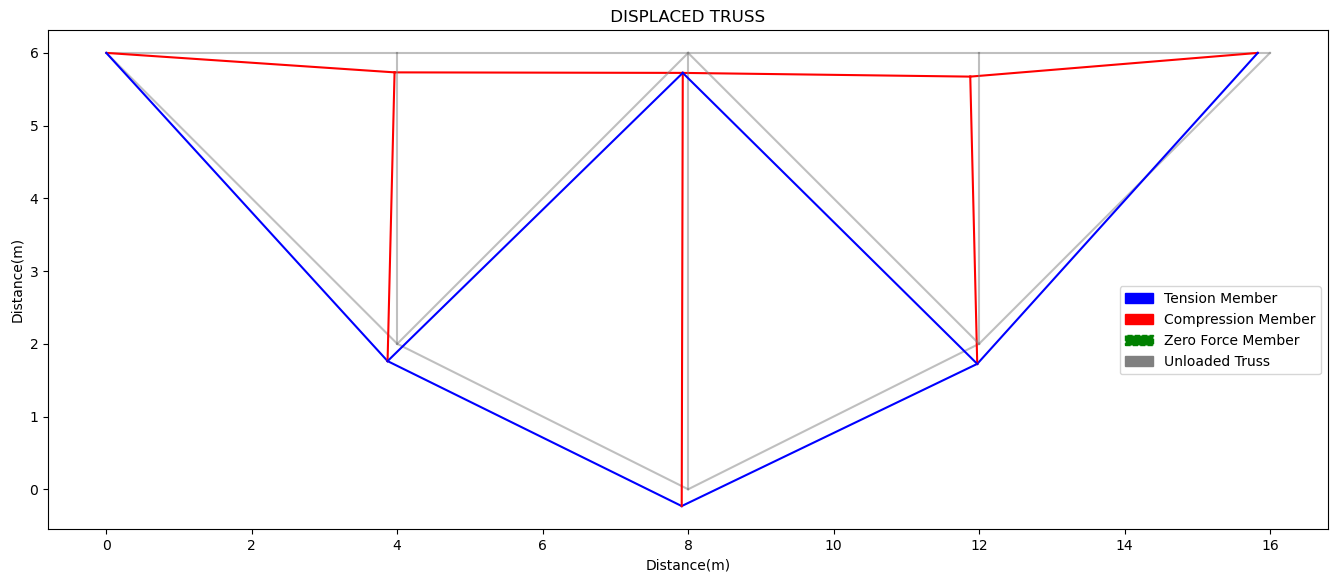

In [112]:
#FIGURE TO PLOT DEFLECTED SHAPE
fig = plt.figure() 
axes = fig.add_axes([0.1,0.1,2,2]) 
fig.gca().set_aspect('equal', adjustable='box')
axes.set_title(' DISPLACED TRUSS ')
axes.set_ylabel('Distance(m)')
axes.set_xlabel('Distance(m)')
for i,member in enumerate(members):
    start_node = member[0]
    end_node = member[1]
    x1 = nodes[start_node-1][0]
    y1 = nodes[start_node-1][1]
    x2 = nodes[end_node-1][0]
    y2 = nodes[end_node-1][1]
    #print(x1,x2,y1,y2)
    axes.plot([x1,x2],[y1,y2],'grey',alpha=0.5)
    dof1 = 2*start_node-2 
    dof2 = 2*start_node-1
    dof3 = 2*end_node-2
    dof4 = 2*end_node-1
    if abs(Member_forces[i])<10:
        axes.plot([x1+xFac*UG[dof1],x2+xFac*UG[dof3]],[y1+xFac*UG[dof2],y2+xFac*UG[dof4]],ls='--',color = 'g') # Zero Force Member
    
    elif Member_forces[i] > 0:
        axes.plot([x1+xFac*UG[dof1],x2+xFac*UG[dof3]],[y1+xFac*UG[dof2],y2+xFac*UG[dof4]],'b') # Members in Tension
    
    else:
        axes.plot([x1+xFac*UG[dof1],x2+xFac*UG[dof3]],[y1+xFac*UG[dof2],y2+xFac*UG[dof4]],'r') # Members in Compression
custom_handles = [
    mpatches.Patch(color='blue',label='Tension Member'),
    mpatches.Patch(color='red', label='Compression Member'),
    mpatches.Patch(color='green',ls = '--', label='Zero Force Member'),
    mpatches.Patch(color='grey', label='Unloaded Truss')
]

# Add a legend with custom handles and labels
plt.legend(handles=custom_handles,bbox_to_anchor=(1, 0.5))
plt.show()